# Main Notebook

Notebook ini berisi tahapan - tahapan utama yang dilakukan dalam penelitian `"Analisis Emosi Terhadap Opini Masyarakat Tentang Vaksin Covid-19 Pada Sosial Media Twitter Menggunakan Support Vector Machine"`

## Import Library

Load library yang akan digunakan dalam penelitian

In [1]:
# generals
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# text preprocessing
import re
import string
import unicodedata
from indoNLP.preprocessing import *
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import *

**configs**

In [2]:
if os.path.isdir("../data/"):
    main_dir = "../"
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/"

SEED = 2022

## Load Dataset

Load dataset yang telah siap untuk diolah. Data merupakan hasil dari proses [sampling](https://github.com/Hyuto/skripsi/blob/master/notebook/sampling.ipynb) dan telah melalui proses
filtering dan labelling secara manual.

In [3]:
data = pd.read_csv(main_dir + "data/sample-data.csv")
data.head()

,date,url,user,content,label
0,2021-09-02 01:39:05+00:00,https://twitter.com/no_nykrstnd/status/1433243...,no_nykrstnd,"-Dari hasil monitoring, calon Vaksin Merah Put...",0.0
1,2021-07-15 06:09:36+00:00,https://twitter.com/DakwahMujahidah/status/141...,DakwahMujahidah,[PODCAST] Ngomong Politik - Ilusi Penguatan Ke...,0.0
2,2021-07-05 08:57:50+00:00,https://twitter.com/gamisjohor/status/14119725...,gamisjohor,3. GAMIS menyambut baik saranan daripada YAB P...,2.0
3,2021-09-09 09:17:58+00:00,https://twitter.com/inyesaw/status/14358952423...,inyesaw,@txtdaribogor Abis vaksin terbitlah positif covid,4.0
4,2021-01-02 04:37:14+00:00,https://twitter.com/pringgolakseno/status/1345...,pringgolakseno,"Gambling, vaksin sama ga divaksin.\nGa divaksi...",4.0


## Data Preprocessing

Melakukan tindakan pertama untuk menyiapkan data sebelum proses pemodelan.

**General Preprocessing**

Melakukan preprocessing terhadap keseluruhan data, berikut adalah tahapan - tahapan yang dilakukan:

1. Menghapus semua baris yang terdapat nilai `NaN` (kosong) di dalamnya.
2. Membenarkan tipe data pada kolom `"tanggal"` dan `"label"`

In [4]:
data.dropna(inplace=True)
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data["label"] = data["label"].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3000 non-null   datetime64[ns]
 1   url      3000 non-null   object        
 2   user     3000 non-null   object        
 3   content  3000 non-null   object        
 4   label    3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 140.6+ KB


**Text Preprocessing**

Melakukan preprocessing terhadap data bertipe teks pada kolom `"content"` yang merupakan komponen utama, berikut adalah tahapan - tahapan yang dilakukan:

1. Case folding
2. Noise removal
   * Menghapus whitespace
   * Mengganti non-ascii karakter
   * Menghapus HTML
   * Menghapus URL
   * Menghapus digit
   * Menghapus tanda baca
3. Mengganti word elongation
4. Mengganti kata gaul (slang words)
5. Menerjemahkan emoji
6. Tokenization and stemming

In [5]:
STEMMER = StemmerFactory().create_stemmer()


def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = (
        unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    )  # replacing non-ascii characters
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)  # replace WE
    text = replace_slang(text)  # replace slang words
    text = text.translate(str.maketrans(string.digits, " " * len(string.digits)))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)  # stemming
    return " ".join(text.split())


data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

  0%|          | 0/3000 [00:00<?, ?it/s]

## Modelling

Membangun dan melatih model yang akan digunakan dalam mengklasifikasikan emosi.

### Distribusi Kelas

Melihat distribusi kelas yang terdapat pada dataset.

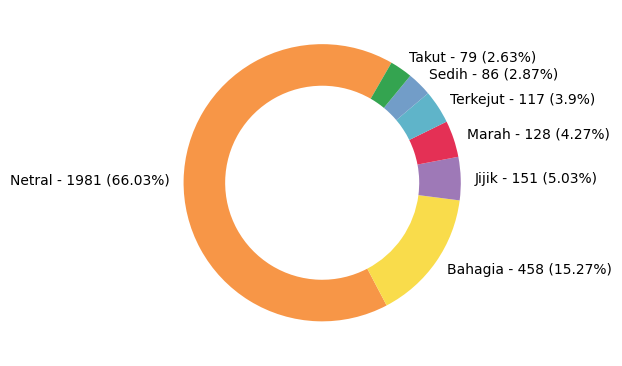

In [6]:
pie_data = data["label"].value_counts()
label_mapper = ["netral", "terkejut", "bahagia", "marah", "takut", "jijik", "sedih"]
color_mapper = ["#F79647", "#5FB4C9", "#F9DC4B", "#E43055", "#34A450", "#9E79B7", "#729DC8"]
labels = [
    (
        f"{label_mapper[pie_data.index[i]].title()} - {pie_data.values[i]}"
        + f" ({round(pie_data.values[i] / sum(pie_data.values) * 100, 2)}%)"
    )
    for i in range(len(pie_data.values))
]

plt.figure(figsize=(4.5, 4.5))
plt.pie(
    pie_data.values,
    labels=labels,
    colors=[color_mapper[x] for x in pie_data.index],
    wedgeprops={"width": 0.3},
    startangle=60,
)

plt.show()

**Insight**

Dapat dilihat dari gambar diatas, kelas netral mendominasi keseluruhan data dengan presentase sebesar 66% atau 1/3 dari keseluruhan data. Kelas - kelas emosi memiliki frekuensi yang terbilang cukup jauh dibanding dengan kelas netral sehingga terdapat masalah _class imbalance_ pada data yang memerlukan penanganan yang khusus. Masalah tersebut dapat ditangani dengan menggunakan metode `startify` yang menjaga distribusi kelas tetap sama pada data latih dan data test saat pembelahan dataset.

### Tuning Hyperparameter 

Mencari hyperparameter terbaik untuk model. `GridSearch` digunakan untuk mencari hyperparameter terbaik dengan mengkobinasikannya dengan `StratifiedKfold` untuk mengetest kekonsistenan kombinasi hyperparameter pada model dengan `f1-weighted` sebagai metrics utamanya.
Berikut adalah kombinasi parameter yang akan diujikan:

```
TF-IDF:
  max-features = [1000, 2000, 3000, 4000, 5000]
SVM:
  C = range(0.2, 4, 0.1)
  kernel = ["linear", "rbf", "poly"]
  coef0 = range(1, 2, 0.1) # if kernel == "poly"
```

In [7]:
pipe = Pipeline(
    [
        ("tf-idf", TfidfVectorizer()),
        ("svm", SVC(probability=True, class_weight="balanced", random_state=SEED)),
    ]
)

cv = StratifiedKFold(shuffle=True, random_state=SEED)
main_params = {
    "tf-idf__max_features": [1000, 2000, 3000, 4000, 5000],
    "svm__C": np.arange(0.2, 4, 0.1),
}
param_grid = [
    {**main_params, "svm__kernel": ["linear", "rbf"]},
    {
        **main_params,
        "svm__coef0": np.arange(1, 2, 0.1),  # np.arange(-0.5, 2, 0.1),
        "svm__kernel": ["poly"],
    },
]

# Run Grid Search approximately 2Hr
# search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", cv=cv, n_jobs=-1, verbose=1)
# search.fit(data["cleaned"].values, data["label"].values)
# search_df = pd.DataFrame(search.cv_results_) # result to df
# search_df.to_csv("CV.csv", index=False)

search_df = pd.read_csv(main_dir + "models/CV-log.csv")  # read CV score
(
    search_df.sort_values(["mean_test_score", "std_test_score"], ascending=[False, True])
    .drop(
        [
            "mean_fit_time",
            "std_fit_time",
            "mean_score_time",
            "std_score_time",
            "split0_test_score",
            "split1_test_score",
            "split2_test_score",
            "split3_test_score",
            "split4_test_score",
        ],
        axis=1,
    )
    .head(10)
)

,param_svm__C,param_svm__kernel,param_tf-idf__max_features,param_svm__coef0,params,mean_test_score,std_test_score,rank_test_score
0,0.4,rbf,1000,NaN,"{'svm__C': 0.4000000000000001, 'svm__kernel': ...",0.666600,0.009923,1
1,0.9,rbf,1000,NaN,"{'svm__C': 0.9000000000000001, 'svm__kernel': ...",0.666196,0.007695,2
2,0.7,rbf,1000,NaN,"{'svm__C': 0.7000000000000002, 'svm__kernel': ...",0.666073,0.008444,3
3,0.8,rbf,2000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.665581,0.010371,4
4,1.3,linear,5000,NaN,"{'svm__C': 1.3000000000000003, 'svm__kernel': ...",0.665114,0.007610,5
5,2.1,linear,5000,NaN,"{'svm__C': 2.100000000000001, 'svm__kernel': '...",0.664862,0.009984,6
6,1.8,linear,5000,NaN,"{'svm__C': 1.8000000000000007, 'svm__kernel': ...",0.664852,0.009358,7
7,2.0,linear,5000,NaN,"{'svm__C': 2.000000000000001, 'svm__kernel': '...",0.664764,0.010648,8
8,0.8,rbf,1000,NaN,"{'svm__C': 0.8000000000000003, 'svm__kernel': ...",0.664558,0.008720,9
9,1.7,linear,5000,NaN,"{'svm__C': 1.7000000000000006, 'svm__kernel': ...",0.664430,0.007852,10


**Insight**

Dapat dilihat dari tabel diatas model yang memiliki rata - rata skor tertinggi merupakan model dengan jenis kernel `rbf` dan `linear`. Model dengan tipe kernel `rbf` mendominasi skor tertinggi dengan nilai parameter `C` dan `max-params` yang rendah sedangkan model dengan tipe kernel `linear` kebalikannya. Dari hasil tabel dipilih model dengan nilai rata - rata skor besar namun memiliki nilai standar deviasi yang kecil. Nilai standar deviasi yang kecil menandakan konsistennya model dalam segala jenis data yang diberikan. Maka dari itu dipilih model kombinasi hyperparameter:

1. `max_features, C, kernel= 1000, 0.9, "rbf"`
2. `max_features, C, kernel= 5000, 1.3, "linear"`

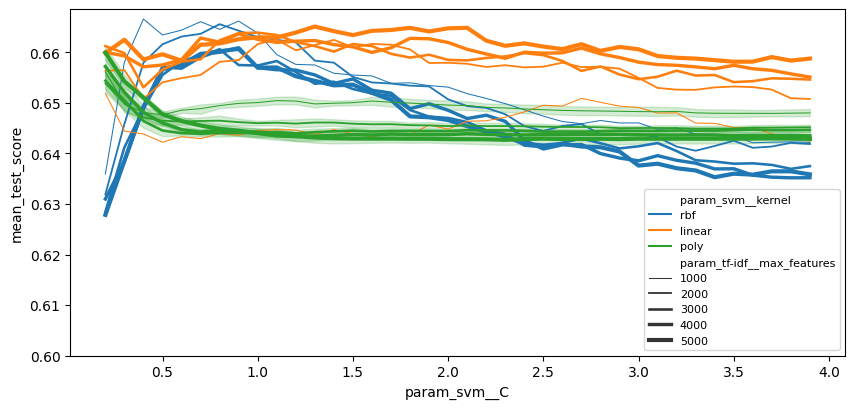

In [8]:
plt.figure(figsize=(10, 4.5))
sns.lineplot(
    data=search_df,
    x="param_svm__C",
    y="mean_test_score",
    hue="param_svm__kernel",
    size="param_tf-idf__max_features",
)
plt.ylim(0.6)
plt.legend(loc="lower right", prop={"size": 8})
plt.show()

**Insight**

Dari gambar diatas dapat dilihat bahwa semakin tinggi nilai parameter C maka terjadi penurunan skor pada model dengan tipe kernel `rbf` dan `poly`, sedangkan model dengan tipe kernel `linear` cukup stabil. Untuk kenaikan nilai pada parameter `max_features` akan terjadi kenaikan skor pada model dengan tipe kernel `linear` sedangkan untuk tipe kernel `rbf` dan `poly` terjadi penurunan.

### Perbandingan dan Pemilihan Model Terbaik

Akan dilakukan perbandingan terhadapat dua jenis model yang telah dipilih sebelumnya untuk digunakan sebagai model utama. Model yang akan dibandingkan adalah model dengan hyperparameter sebagai berikut:

1. `max_features, C, kernel= 1000, 0.9, "rbf"`
2. `max_features, C, kernel= 5000, 1.3, "linear"`

**Model dengan Tipe Kernel RBF**

Akan dibangun dan dilatih model dengan tipe kernel `rbf` dengan hyperparameter yang sudah ditentukan sebelumnya.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    data["cleaned"].values,
    data["label"].values,
    test_size=0.2,
    random_state=1000,
    stratify=data["label"].values,
)

pipe_rbf = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=1000)),
        (
            "svm",
            SVC(C=0.9, kernel="rbf", probability=True, class_weight="balanced", random_state=SEED),
        ),
    ]
)

pipe_rbf.fit(x_train, y_train)
pd.DataFrame(classification_report(y_test, pipe_rbf.predict(x_test), output_dict=True)).T

,precision,recall,f1-score,support
0,0.819549,0.825758,0.822642,396.000000
1,0.111111,0.086957,0.097561,23.000000
2,0.564356,0.619565,0.590674,92.000000
3,0.307692,0.307692,0.307692,26.000000
4,0.333333,0.062500,0.105263,16.000000
5,0.270833,0.433333,0.333333,30.000000
6,0.400000,0.117647,0.181818,17.000000
accuracy,0.683333,0.683333,0.683333,0.683333
macro avg,0.400982,0.350493,0.348426,600.000000
weighted avg,0.678793,0.683333,0.675212,600.000000


Dapat dilihat dari tabel diatas model dengan tipe kernel `rbf` mendapatkan hasil yang cukup baik dengan skor f1 sebesar 67,52%.

**Model dengan Tipe Kernel Linear**

Akan dibangun dan dilatih model dengan tipe kernel `linear` dengan hyperparameter yang sudah ditentukan sebelumnya.

In [10]:
pipe_linear = Pipeline(
    [
        ("tf-idf", TfidfVectorizer(max_features=5000)),
        (
            "svm",
            SVC(
                C=1.3, kernel="linear", probability=True, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

pipe_linear.fit(x_train, y_train)
pd.DataFrame(classification_report(y_test, pipe_linear.predict(x_test), output_dict=True)).T

,precision,recall,f1-score,support
0,0.859155,0.770202,0.812250,396.000000
1,0.166667,0.173913,0.170213,23.000000
2,0.542373,0.695652,0.609524,92.000000
3,0.281250,0.346154,0.310345,26.000000
4,0.250000,0.187500,0.214286,16.000000
5,0.265306,0.433333,0.329114,30.000000
6,0.300000,0.176471,0.222222,17.000000
accuracy,0.668333,0.668333,0.668333,0.668333
macro avg,0.380679,0.397604,0.381136,600.000000
weighted avg,0.697214,0.668333,0.677985,600.000000


Dapat dilihat dari tabel diatas model dengan tipe kernel `linear` mendapatkan hasil yang cukup baik dengan skor f1 sebesar 67,52%. Skor tersebut sedikit lebih tinggi dibandingkan dengan skor f1 yang diperoleh oleh model dengan tipe kernel `rbf`.

**Plotting Confusion Matrix**

Akan dibentuk confusion matrix dari kedua model untuk dapat membandingkan lebih jauh kedua model tersebut

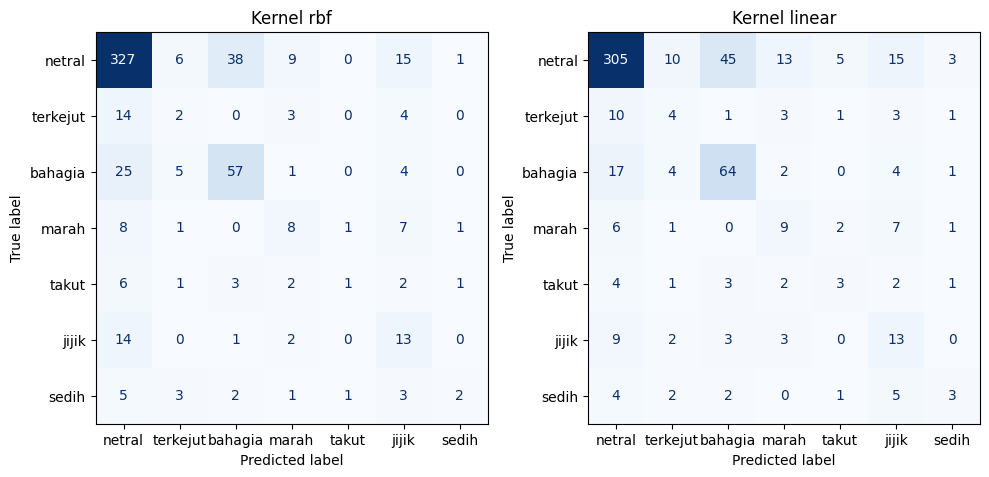

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cm1 = ConfusionMatrixDisplay(
    confusion_matrix(y_test, pipe_rbf.predict(x_test)), display_labels=label_mapper
)
cm1.plot(ax=ax1, cmap="Blues", colorbar=False)
ax1.set_title("Kernel rbf")
cm2 = ConfusionMatrixDisplay(
    confusion_matrix(y_test, pipe_linear.predict(x_test)), display_labels=label_mapper
)
cm2.plot(ax=ax2, cmap="Blues", colorbar=False)
ax2.set_title("Kernel linear")
plt.tight_layout()
plt.show()

**Insight**

Dapat dilihat dari ganbar diatas, pada confusion matrix model bertipe kernel `rbf` mempunyai kemampuan deteksi yang lebih baik untuk kelas netral dibandingkan dengan model dengan tipe kernel `linear`. Namun model dengan tipe kernel `linear` memiliki performa yang lebih baik untuk mendeteksi kelas emosi dibandingkan dengan model bertipe kernel `rbf`. Oleh karena itu diambil keputusan untuk menggunakan model bertipe kernel `linear` sebagai model utama karena diperlukan model yang lebih baik dalam mendeteksi kelas emosi dibandingkan kelas netral.

## Mendeteksi Emosi Keseluruhan Data

Menggunakan model utama akan dilakukan pendeteksian emosi pada data penuh.

**Load Full Data**

In [12]:
list_data = [
    "januari-2021.csv",
    "februari-2021.csv",
    "maret-2021.csv",
    "april-2021.csv",
    "mei-2021.csv",
    "juni-2021.csv",
    "juli-2021.csv",
    "agustus-2021.csv",
    "september-2021.csv",
    "oktober-2021.csv",
    "november-2021.csv",
    "desember-2021.csv",
]

data_full = pd.concat([pd.read_csv(f"{main_dir}data/{x}") for x in list_data])
data_full["date"] = pd.to_datetime(data_full["date"]).dt.tz_localize(None)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457993 entries, 0 to 15958
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     457993 non-null  datetime64[ns]
 1   url      457993 non-null  object        
 2   user     457993 non-null  object        
 3   content  457993 non-null  object        
 4   likes    292455 non-null  float64       
 5   retweet  292455 non-null  float64       
 6   reply    292455 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 28.0+ MB


**Preprocessing dan Mendeteksi Emosi**

Melakukan preprocessing dan mendeteksi emosi pada setiap tweet pada data panuh.

In [13]:
data_full.drop_duplicates("content", inplace=True)

# preprocessing data
# data_full["cleaned"] = [preprocessing(x) for x in tqdm(data_full["content"].values)] # run for 30 min

# predicting emotion
# data_full["predicted"] = [pipe_linear.predict(x) for x in tqdm(data_full["cleaned"].values)] # run for 9 min

# saving cleaned and predicted data
# os.makedirs("output", exist_ok=True)
# data_full[["cleaned", "predicted"]].to_csv('output/cleaned-predicted.csv.zip', index=False,
#                                           compression={'method': 'zip', 'archive_name': 'cleaned-predicted.csv'})

# use cached data for faster running time
data_full[["cleaned", "predicted"]] = pd.read_csv(
    f"{main_dir}data/cleaned-predicted.csv.zip"
).values
data_full.head()

,date,url,user,content,likes,retweet,reply,cleaned,predicted
0,2021-01-31 23:56:43,https://twitter.com/Sistyriii/status/135602867...,Sistyriii,"""Bentar deh, dlu kan aku di vaksin campak smaa...",NaN,NaN,NaN,bentar deh dulu kan aku di vaksin campak sama ...,1
1,2021-01-31 23:55:07,https://twitter.com/Sistyriii/status/135602826...,Sistyriii,"Kemarin bokap bilang \n""Katanya wakil walikota...",NaN,NaN,NaN,kemarin bokap bilang kata wakil walikota depok...,5
2,2021-01-31 23:55:04,https://twitter.com/AhmadNorMaulana/status/135...,AhmadNorMaulana,Dokter Sebut Vaksin COVID-19 Aman Meski Ada Ef...,0.0,0.0,0.0,dokter sebut vaksin covid aman meski ada efek ...,0
3,2021-01-31 23:45:08,https://twitter.com/DIMASBA20908752/status/135...,DIMASBA20908752,@DonAdam68 Apa tidak pernah memikirkan nasip r...,1.0,0.0,0.0,donadam apa tidak pernah pikir nasip rakyat ya...,0
4,2021-01-31 23:38:40,https://twitter.com/datukhensem/status/1356024...,datukhensem,Salah vaksin hantar kat Myanmar ni. Orang nak ...,4.0,4.0,0.0,salah vaksin hantar kat myanmar nih orang nak ...,0


## Export Model

Export main model dalam format `onnx` agar lebih mudah di deploy di segala bentuk device.

In [14]:
from onnx.checker import check_model
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

os.makedirs("output", exist_ok=True)

initial_type = [("words", StringTensorType([None, 1]))]
options = {"svm": {"zipmap": False}}
onnx_model = convert_sklearn(pipe_linear, initial_types=initial_type, options=options)
check_model(onnx_model)
with open("output/model-svm-linear-large.onnx", "wb") as writer:
    writer.write(onnx_model.SerializeToString())